In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 11 16:44:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm

# Prerequisites

In [4]:
!pip install torch torchvision pytorchvideo mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00

In [5]:
!unzip /content/drive/MyDrive/Dataset/videos.zip -d /content/videos

Streaming output truncated to the last 5000 lines.
  inflating: /content/videos/57382.mp4  
  inflating: /content/videos/57385.mp4  
  inflating: /content/videos/57391.mp4  
  inflating: /content/videos/57392.mp4  
  inflating: /content/videos/57393.mp4  
  inflating: /content/videos/57394.mp4  
  inflating: /content/videos/57395.mp4  
  inflating: /content/videos/57396.mp4  
  inflating: /content/videos/57397.mp4  
  inflating: /content/videos/57408.mp4  
  inflating: /content/videos/57410.mp4  
  inflating: /content/videos/57411.mp4  
  inflating: /content/videos/57412.mp4  
  inflating: /content/videos/57413.mp4  
  inflating: /content/videos/57414.mp4  
  inflating: /content/videos/57415.mp4  
  inflating: /content/videos/57416.mp4  
  inflating: /content/videos/57417.mp4  
  inflating: /content/videos/57430.mp4  
  inflating: /content/videos/57436.mp4  
  inflating: /content/videos/57437.mp4  
  inflating: /content/videos/57438.mp4  
  inflating: /content/videos/57439.mp4  
  infl

# Class names and label map

In [6]:
class_names = []
class_idx = {}

with open('/content/drive/MyDrive/Dataset/wlasl_class_list.txt', 'r') as f:
    for line in f:
        idx, word = line.strip().split('\t')
        idx = int(idx)
        class_names.append(word)
        class_idx[word] = idx

In [7]:
print(f'# classes: {len(class_names)}')
print(f'First 5: {class_names[:5]}')

# classes: 2000
First 5: ['book', 'drink', 'computer', 'before', 'chair']


In [8]:
len(class_idx)
print(f'First 5: {list(class_idx.items())[:5]}')

First 5: [('book', 0), ('drink', 1), ('computer', 2), ('before', 3), ('chair', 4)]


In [9]:
with open('/content/drive/MyDrive/Dataset/missing.txt', 'r') as f:
    missing = set(line.strip() for line in f if line.strip())

missing_list = list(missing)
print(missing_list[1:5])

['36940', '61888', '68129', '67815']


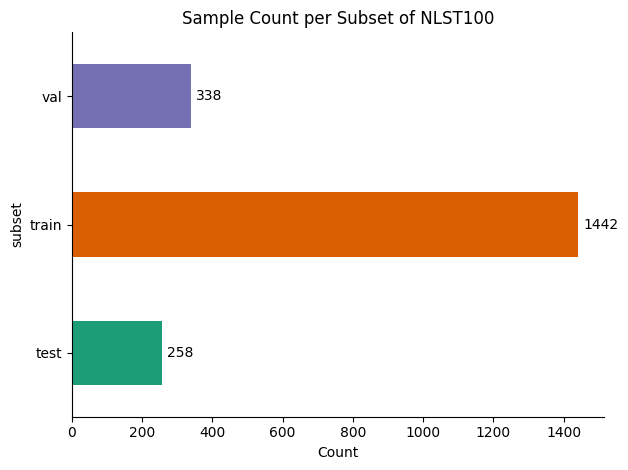

In [10]:
def show_split_nlst100(json_path='/content/drive/MyDrive/Dataset/nslt_100.json', dataset_name='NLST100'):
    with open(json_path, 'r') as f:
        data = json.load(f)

    records = []
    for sample_id, info in data.items():
        subset = info.get('subset', 'unknown')
        records.append({'sample_id': sample_id, 'subset': subset})

    df = pd.DataFrame(records)

    counts = df.groupby('subset').size()

    ax = counts.plot(kind='barh', color=sns.color_palette('Dark2'))

    plt.gca().spines[['top', 'right']].set_visible(False)

    for i, v in enumerate(counts):
        plt.text(v + max(counts) * 0.01, i, str(v), va='center')

    plt.xlabel("Count")
    plt.title(f"Sample Count per Subset of {dataset_name}")
    plt.tight_layout()
    plt.show()

show_split_nlst100()

# Landmarks Extration

In [ ]:
import mediapipe as mp
print(mp.__version__)

In [ ]:
from multiprocessing import Pool, cpu_count
import mediapipe as mp

mp_holistic = mp.solutions.holistic

def extract_landmarks_worker(args):
    vid_id, video_dir, output_dir, num_frames, img_size = args

    video_path = os.path.join(video_dir, f"{vid_id}.mp4")
    if not os.path.isfile(video_path):
        return

    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frames.append(frame)
    cap.release()

    if len(frames) == 0:
        return

    indices = np.linspace(0, len(frames) - 1, num=num_frames).astype(int)
    sampled_frames = [frames[i] for i in indices]

    all_landmarks = []

    with mp_holistic.Holistic(static_image_mode=True) as holistic_model:
        for frame in sampled_frames:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic_model.process(rgb)

            # ------ POSE: 33 KEYPOINTS ------
            pose = [[0] * 3] * 33
            if results.pose_landmarks:
                pose = [[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]

            # ------ FACE: 468 KEYPOINTS ------
            face = [[0] * 3] * 468
            if results.face_landmarks:
                face = [[lm.x, lm.y, lm.z] for lm in results.face_landmarks.landmark]

            # ------ LEFT HAND: 21 KEYPOINTS ------
            left = [[0] * 3] * 21
            if results.left_hand_landmarks:
                left = [[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]

            # ------ RIGHT HAND: 21 KEYPOINTS ------
            right = [[0] * 3] * 21
            if results.right_hand_landmarks:
                right = [[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]

            # (543, 3)
            all_landmarks.append(pose + face + left + right)

    # (T, 543, 3)
    landmarks = np.array(all_landmarks)
    np.save(os.path.join(output_dir, f"{vid_id}.npy"), landmarks)

def extract_landmarks_parallel(
    data_path,
    video_dir,
    output_dir,
    num_frames=64,
    img_size=224,
    num_workers=None
):
    os.makedirs(output_dir, exist_ok=True)

    with open(data_path, 'r') as f:
        metadata = json.load(f)

    args_list = [
        (vid_id, video_dir, output_dir, num_frames, img_size)
        for vid_id in metadata
    ]

    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)

    with Pool(processes=num_workers) as pool:
        list(tqdm(pool.imap_unordered(extract_landmarks_worker, args_list), total=len(args_list)))

In [ ]:
import time
import platform

start_time = time.time()
print(f"[INFO] Device: {platform.processor() or platform.machine()}")

extract_landmarks_parallel(
    data_path='/content/drive/MyDrive/Dataset/nslt_100.json',
    video_dir='/content/videos',
    output_dir='/content/landmarks-64',
    num_frames=64,
    img_size=224,
    num_workers=4
)

end_time = time.time()
print(f"\n[INFO] Execution Time: {end_time - start_time:.2f} seconds")

In [ ]:
from google.colab import files
!zip -r landmarks-64.zip landmarks-64/
files.download('landmarks-64.zip')

# Dataset

In [11]:
!unzip /content/drive/MyDrive/Dataset/landmarks-64.zip -d /content/landmarks-64

Archive:  /content/drive/MyDrive/Dataset/landmarks-64.zip
  inflating: /content/landmarks-64/00618.npy  
  inflating: /content/landmarks-64/00623.npy  
  inflating: /content/landmarks-64/00624.npy  
  inflating: /content/landmarks-64/00625.npy  
  inflating: /content/landmarks-64/00626.npy  
  inflating: /content/landmarks-64/00627.npy  
  inflating: /content/landmarks-64/00628.npy  
  inflating: /content/landmarks-64/00629.npy  
  inflating: /content/landmarks-64/00630.npy  
  inflating: /content/landmarks-64/00631.npy  
  inflating: /content/landmarks-64/00632.npy  
  inflating: /content/landmarks-64/00633.npy  
  inflating: /content/landmarks-64/00634.npy  
  inflating: /content/landmarks-64/00635.npy  
  inflating: /content/landmarks-64/00636.npy  
  inflating: /content/landmarks-64/00638.npy  
  inflating: /content/landmarks-64/00639.npy  
  inflating: /content/landmarks-64/01382.npy  
  inflating: /content/landmarks-64/01383.npy  
  inflating: /content/landmarks-64/01384.npy  
  

In [12]:
import torch
from torch.utils.data import Dataset

class WLDataset(Dataset):
    def __init__(self, data_path, video_dir, landmark_dir, subset='train', num_frames=64, img_size=224):
        self.num_frames = num_frames
        self.img_size = img_size
        self.video_dir = video_dir
        self.landmark_dir = landmark_dir

        with open(data_path, 'r') as f:
            metadata = json.load(f)

        self.samples = []
        for vid_id, info in metadata.items():
            if info["subset"] == subset:
                label = info["action"][0]
                video_path = os.path.join(video_dir, f"{vid_id}.mp4")
                landmark_path = os.path.join(landmark_dir, f"{vid_id}.npy")
                if os.path.exists(video_path) and os.path.exists(landmark_path):
                    self.samples.append((video_path, landmark_path, label))

    def __len__(self):
        return len(self.samples)

    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (self.img_size, self.img_size))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()

        indices = np.linspace(0, len(frames)-1, num=self.num_frames).astype(int)
        frames = [frames[i] for i in indices]
        frames = np.stack(frames)

        # [C, T, H, W]
        frames = frames.transpose(3, 0, 1, 2)
        return frames

    def __getitem__(self, idx):
        video_path, landmark_path, label = self.samples[idx]
        video = self._load_video(video_path)
        landmarks = np.load(landmark_path)

        return {
            'video': torch.tensor(video, dtype=torch.float32),
            'landmarks': torch.tensor(landmarks, dtype=torch.float32),
            'mask': torch.ones(self.num_frames),
            'label': torch.tensor(label, dtype=torch.long),
            'video_path': video_path
        }

In [13]:
from torch.utils.data import DataLoader

dataset = WLDataset(
    data_path='/content/drive/MyDrive/Dataset/nslt_100.json',
    video_dir='/content/videos',
    landmark_dir='/content/landmarks-64',
    subset='train',
    num_frames=64,
    img_size=224
)

In [14]:
len(dataset)

1442

In [15]:
for i in range(5):
    sample = dataset[i]
    print(
        sample['video'].shape,
        sample['landmarks'].shape,
        sample['mask'].shape,
        sample['label']
    )

torch.Size([3, 64, 224, 224]) torch.Size([64, 543, 3]) torch.Size([64]) tensor(77)
torch.Size([3, 64, 224, 224]) torch.Size([64, 543, 3]) torch.Size([64]) tensor(82)
torch.Size([3, 64, 224, 224]) torch.Size([64, 543, 3]) torch.Size([64]) tensor(82)
torch.Size([3, 64, 224, 224]) torch.Size([64, 543, 3]) torch.Size([64]) tensor(82)
torch.Size([3, 64, 224, 224]) torch.Size([64, 543, 3]) torch.Size([64]) tensor(82)


In [16]:
type(dataset)

__main__.WLDataset

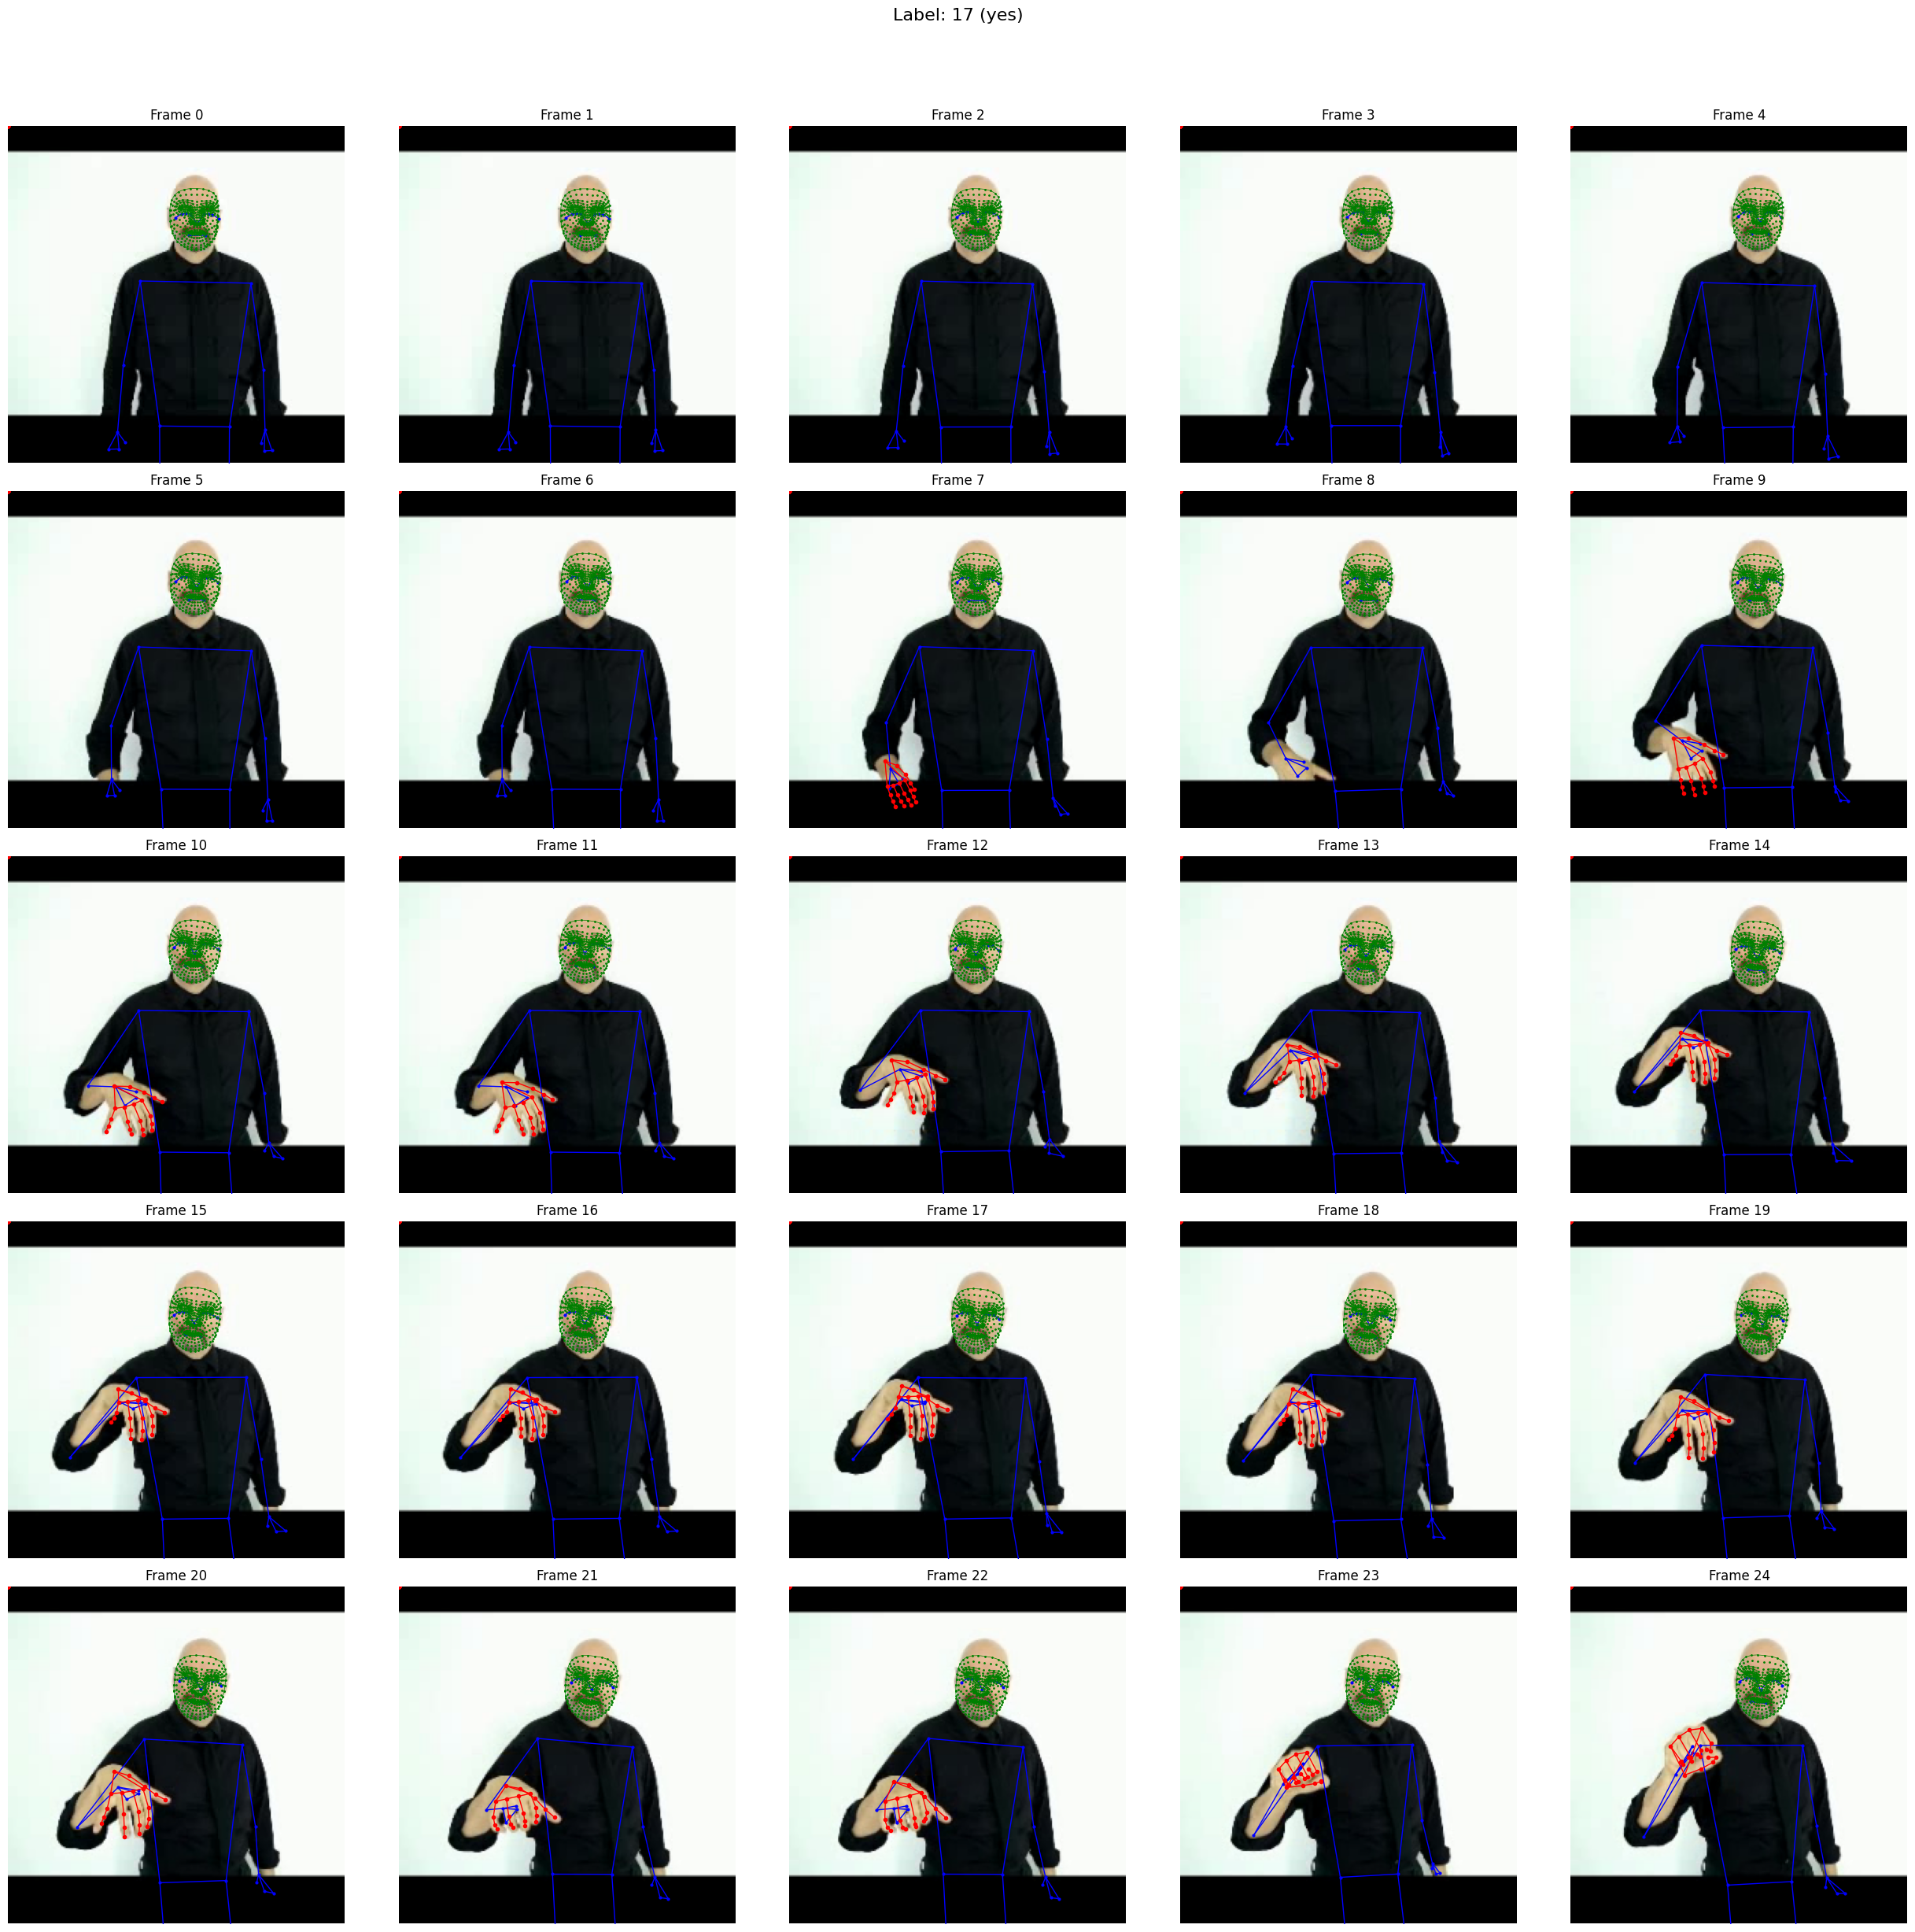

In [17]:
from mediapipe.python.solutions.pose import POSE_CONNECTIONS
from mediapipe.python.solutions.hands import HAND_CONNECTIONS
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_CONTOURS

sample = dataset[35]
frames = sample['video'].permute(1, 2, 3, 0).numpy()
landmarks = sample['landmarks'].numpy()
label = sample['label']

rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for i in range(rows * cols):
    img = frames[i].astype(np.uint8)
    lmks = landmarks[i]
    h, w = img.shape[0], img.shape[1]

    axes[i].imshow(img)
    axes[i].set_xlim(0, w)
    axes[i].set_ylim(h, 0)
    axes[i].axis('off')
    axes[i].set_title(f"Frame {i}")

    # ------ POSE: 33 KEYPOINTS ------
    pose = lmks[0:33]
    axes[i].plot(pose[:, 0] * w, pose[:, 1] * h, 'bo', markersize=2)
    for a, b in POSE_CONNECTIONS:
        if a < 33 and b < 33:
            x1, y1 = pose[a, 0] * w, pose[a, 1] * h
            x2, y2 = pose[b, 0] * w, pose[b, 1] * h
            axes[i].plot([x1, x2], [y1, y2], 'b', linewidth=1)

    # ------ FACE: 468 KEYPOINTS ------
    face = lmks[33:501]
    axes[i].plot(face[:, 0] * w, face[:, 1] * h, 'go', markersize=1)
    for a, b in FACEMESH_CONTOURS:
        x1, y1 = face[a, 0] * w, face[a, 1] * h
        x2, y2 = face[b, 0] * w, face[b, 1] * h
        axes[i].plot([x1, x2], [y1, y2], color='green', linewidth=0.5)

    # ------ LEFT HAND: 21 KEYPOINTS ------
    l_hand = lmks[501:522]
    axes[i].plot(l_hand[:, 0] * w, l_hand[:, 1] * h, 'ro', markersize=3)
    for a, b in HAND_CONNECTIONS:
        x1, y1 = l_hand[a, 0] * w, l_hand[a, 1] * h
        x2, y2 = l_hand[b, 0] * w, l_hand[b, 1] * h
        axes[i].plot([x1, x2], [y1, y2], 'r', linewidth=1)

    # ------ RIGHT HAND: 21 KEYPOINTS ------
    r_hand = lmks[522:543]
    axes[i].plot(r_hand[:, 0] * w, r_hand[:, 1] * h, 'ro', markersize=3)
    for a, b in HAND_CONNECTIONS:
        x1, y1 = r_hand[a, 0] * w, r_hand[a, 1] * h
        x2, y2 = r_hand[b, 0] * w, r_hand[b, 1] * h
        axes[i].plot([x1, x2], [y1, y2], 'r', linewidth=1)

index_to_label = {v: k for k, v in class_idx.items()}
fig.suptitle(f"Label: {label.item()} ({index_to_label[label.item()]})", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('landmarks.png', dpi=300)
plt.show()

# Partitioning

In [18]:
import random

data_path='/content/drive/MyDrive/Dataset/nslt_100.json'
video_dir='/content/videos'
landmark_dir='/content/landmarks-64'

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

train_dataset = WLDataset(
    data_path=data_path,
    video_dir=video_dir,
    landmark_dir=landmark_dir,
    subset='train',
    num_frames=64,
    img_size=224,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [19]:
train_loader

In [20]:
for batch in train_loader:
    print("Batch keys:", batch.keys())
    print("Video shape:", batch["video"].shape)
    print("Landmarks shape:", batch["landmarks"].shape)
    print("Mask shape:", batch["mask"].shape)
    print("Labels shape:", batch["label"].shape)
    break

Batch keys: dict_keys(['video', 'landmarks', 'mask', 'label', 'video_path'])
Video shape: torch.Size([8, 3, 64, 224, 224])
Landmarks shape: torch.Size([8, 64, 543, 3])
Mask shape: torch.Size([8, 64])
Labels shape: torch.Size([8])


In [21]:
val_dataset = WLDataset(
    data_path=data_path,
    video_dir=video_dir,
    landmark_dir=landmark_dir,
    subset='val',
    num_frames=64,
    img_size=224
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.video import s3d, S3D_Weights

# -----------------------------------------
# S3D Video Backbone
# -----------------------------------------
class S3DPretrained(nn.Module):
    def __init__(self):
        super().__init__()
        self.s3d = s3d(weights=S3D_Weights.DEFAULT)
        self.s3d.classifier = nn.Identity()

        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 64, 224, 224)
            dummy_output = self.s3d(dummy_input)
        self.video_feat_dim = dummy_output.shape[1]

    def forward(self, x):
        return self.s3d(x)
    
# -----------------------------------------
# Spatial Partition: Face, Hands, Pose
# -----------------------------------------
class SpatialPartition(nn.Module):
    def __init__(self):
        super().__init__()
        self.pose_indices = list(range(0, 33))
        self.left_hand_indices = list(range(33, 54))
        self.right_hand_indices = list(range(54, 75))
        self.face_indices = list(range(75, 543))

    def forward(self, landmarks):
        pose = landmarks[:, :, self.pose_indices, :]
        left = landmarks[:, :, self.left_hand_indices, :]
        right = landmarks[:, :, self.right_hand_indices, :]
        face = landmarks[:, :, self.face_indices, :]
        return left, right, pose, face

# -----------------------------------------
# Spatial Attention
# -----------------------------------------
class SpatialAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.q = nn.Linear(input_dim, hidden_dim)
        self.k = nn.Linear(input_dim, hidden_dim)
        self.v = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        q = self.q(x)  
        k = self.k(x)
        v = self.v(x)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)  
        attn_weights = F.softmax(attn_scores, dim=-1)  
        attn_output = torch.matmul(attn_weights, v)  

        return attn_output.mean(dim=2)  

# -----------------------------------------
# Temporal Partition
# -----------------------------------------
class TemporalPartition(nn.Module):
    def __init__(self, window_size=8, overlap=4):
        super().__init__()
        self.window_size = window_size
        self.overlap = overlap

    def forward(self, x):
        B, T, D = x.size()
        stride = self.window_size - self.overlap

        if T < self.window_size:
            pad_len = self.window_size - T
            x = F.pad(x, (0, 0, 0, pad_len))  
            T = x.size(1)

        segments = []
        for start in range(0, T - self.window_size + 1, stride):
            segments.append(x[:, start:start + self.window_size, :])

        if len(segments) == 0:
            segments.append(x[:, -self.window_size:, :])

        return torch.stack(segments, dim=1)  

# -----------------------------------------
# Temporal Attention
# -----------------------------------------
class TemporalAttention(nn.Module):
    def __init__(self, input_dim, hidden_size, attn_dim=128):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_size, batch_first=True, bidirectional=True)

        self.q_proj = nn.Linear(2 * hidden_size, attn_dim)
        self.k_proj = nn.Linear(2 * hidden_size, attn_dim)
        self.v_proj = nn.Linear(2 * hidden_size, attn_dim)

    def forward(self, segments):
        B, S, W, D = segments.shape
        segments = segments.view(B * S, W, D)  

        gru_out, _ = self.gru(segments)  
        segment_feats = gru_out[:, -1, :]  
        segment_feats = segment_feats.view(B, S, -1)  

        Q = self.q_proj(segment_feats)  
        K = self.k_proj(segment_feats)  
        V = self.v_proj(segment_feats)  

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)  
        attn_weights = F.softmax(attn_scores, dim=-1)  

        attended = torch.matmul(attn_weights, V)  
        output = attended.mean(dim=1)  

        return output

# -----------------------------------------
# Landmark Transformer
# -----------------------------------------
class LandmarkTransformer(nn.Module):
    def __init__(self, input_dim=3, embed_dim=128, hidden_size=128, window_size=8, overlap=4):
        super().__init__()
        self.partition = SpatialPartition()
        self.att_left = SpatialAttention(input_dim, embed_dim)
        self.att_right = SpatialAttention(input_dim, embed_dim)
        self.att_pose = SpatialAttention(input_dim, embed_dim)
        self.att_face = SpatialAttention(input_dim, embed_dim)

        self.temporal_partition = TemporalPartition(window_size, overlap)
        self.temporal_att = TemporalAttention(embed_dim, hidden_size, attn_dim=embed_dim)

    def forward(self, x):
        # x: (B, T, N, D)
        left, right, pose, face = self.partition(x)

        left_feat = self.att_left(left)    
        right_feat = self.att_right(right)   
        pose_feat = self.att_pose(pose)      
        face_feat = self.att_face(face)      

        combined = left_feat + right_feat + pose_feat + face_feat  
        segments = self.temporal_partition(combined)               
        final_feat = self.temporal_att(segments)                   
        return final_feat

# -----------------------------------------
# Final S3D-LandmarksNet Model
# -----------------------------------------
class SLN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.video_backbone = S3DPretrained()
        self.landmark_encoder = LandmarkTransformer()
        total_feat_dim = self.video_backbone.video_feat_dim + 2 * 128
        self.classifier = nn.Sequential(
            nn.Linear(total_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, video, landmarks, mask=None):
        video_feat = self.video_backbone(video)
        landmark_feat = self.landmark_encoder(landmarks)
        fused = torch.cat([video_feat, landmark_feat], dim=1)
        return self.classifier(fused)

# Train Script - Pytorch

## Script

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def top_k_accuracy(output, target, k=5):
    _, pred = output.topk(k, 1, True, True)
    return (pred == target.view(-1, 1)).sum().item() / target.size(0)

def evaluate(model, data_loader, criterion, device, top_k=5, use_amp=True):
    model.eval()
    running_loss = 0.0
    correct = 0
    topk_correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            video = batch['video'].to(device, non_blocking=True)
            landmarks = batch['landmarks'].to(device, non_blocking=True)
            mask = batch['mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(video, landmarks, mask)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

            _, topk_preds = outputs.topk(top_k, dim=1)
            topk_correct += (topk_preds == labels.view(-1, 1)).sum().item()
            total += labels.size(0)

    acc = (correct / total)*100
    topk_acc = (topk_correct / total)*100
    loss = (running_loss / total)

    return loss, acc, topk_acc

def train(model, train_loader, val_loader, criterion, optimizer, device,
          epochs=10, patience=5, top_k=5, use_amp=True, clip_grad=True, max_norm=1.0,
          scheduler=None, log_dir="runs/exp", log_path="logs/training_log.json", validation_step=1):
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    random.seed(42)
    np.random.seed(42)

    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)

    log_dir = os.path.dirname(log_path)
    if log_dir != "":
        os.makedirs(log_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = f".checkpoints/best_model_{timestamp}.pth"
    os.makedirs(".checkpoints", exist_ok=True)

    best_val_acc = 0.0
    best_epoch = 0

    scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

    log = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": [],
        "val_topk": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)

        for batch in loop:
            video = batch['video'].to(device, non_blocking=True)
            landmarks = batch['landmarks'].to(device, non_blocking=True)
            mask = batch['mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(video, landmarks, mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if clip_grad:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix({
                'train_loss': f"{running_loss / total:.4f}",
                'train_acc': f"{correct / total:.2f}"
            })

        train_loss = running_loss / total
        train_acc = (correct / total)*100
        
        if (epoch + 1) % validation_step == 0 or (epoch + 1) == epochs:
            val_loss, val_acc, val_topk = evaluate(model, val_loader, criterion, device, top_k=top_k, use_amp=use_amp)

            if scheduler is not None:
                scheduler.step(val_loss)

                current_lrs = scheduler.get_last_lr()

                for i, lr in enumerate(current_lrs):
                    writer.add_scalar(f"Learning_Rate/group_{i}", lr, epoch)

            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Loss/Val", val_loss, epoch)
            writer.add_scalar("Accuracy/Train", train_acc, epoch)
            writer.add_scalar("Accuracy/Val", val_acc, epoch)
            writer.add_scalar(f"Top{top_k}_Accuracy/Val", val_topk, epoch)

            log["train_loss"].append(train_loss)
            log["train_acc"].append(train_acc)
            log["val_loss"].append(val_loss)
            log["val_acc"].append(val_acc)
            log["val_topk"].append(val_topk)

            print(f"Epoch [{epoch+1}/{epochs}] - learning rates: {current_lrs}:"
                f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.2f}, "
                f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}, val_top{top_k}_acc: {val_topk:.2f}", end='')
        else:
            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Accuracy/Train", train_acc, epoch)
            print(f"Epoch [{epoch+1}/{epochs}] - train_loss: {train_loss:.4f}, train_acc: {train_acc:.2f}")
            
        if val_acc > best_val_acc :
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), checkpoint_path)
            print(f" | Saved new best model (val_acc: {val_acc:.2f})")
        else:
            print()

        if epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    writer.close()

    with open(log_path, 'w') as f:
        json.dump(log, f)

## Train

In [ ]:
num_classes = 100
batch_size = 8
num_epochs = 200
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = SLN(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=num_epochs,
    patience=5,
    top_k=5,
    use_amp=True,
    clip_grad=True,
    max_norm=1.0,
    scheduler=scheduler,
    log_dir="runs/exp1",
    validation_step=5
)

cuda


Downloading: "https://download.pytorch.org/models/s3d-d76dad2f.pth" to /root/.cache/torch/hub/checkpoints/s3d-d76dad2f.pth
100%|██████████| 32.0M/32.0M [00:00<00:00, 195MB/s]
Epoch [5/200]: 100%|██████████| 181/181 [00:48<00:00,  3.77it/s, train_loss=4.6002, train_acc=0.02]


Epoch [5/200] - learning rates: [0.0001]:train_loss: 4.6002, train_acc: 2.36, val_loss: 4.4088, val_acc: 3.40, val_top5_acc: 15.40 | Saved new best model (val_acc: 3.40)


Epoch [10/200]: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s, train_loss=4.2312, train_acc=0.07]


Epoch [10/200] - learning rates: [0.0001]:train_loss: 4.2312, train_acc: 6.52, val_loss: 3.9742, val_acc: 7.70, val_top5_acc: 33.29 | Saved new best model (val_acc: 7.70)


Epoch [15/200]: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s, train_loss=3.7820, train_acc=0.12]


Epoch [15/200] - learning rates: [0.0001]:train_loss: 3.7820, train_acc: 12.48, val_loss: 3.1506, val_acc: 23.93, val_top5_acc: 55.55 | Saved new best model (val_acc: 23.93)


Epoch [20/200]: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s, train_loss=3.2834, train_acc=0.23]


Epoch [20/200] - learning rates: [0.0001]:train_loss: 3.2834, train_acc: 23.37, val_loss: 2.4738, val_acc: 39.18, val_top5_acc: 74.48 | Saved new best model (val_acc: 39.18)


Epoch [25/200]: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s, train_loss=2.8407, train_acc=0.31]


Epoch [25/200] - learning rates: [0.0001]:train_loss: 2.8407, train_acc: 31.48, val_loss: 2.2425, val_acc: 46.74, val_top5_acc: 84.19 | Saved new best model (val_acc: 46.74)


Epoch [30/200]: 100%|██████████| 181/181 [00:45<00:00,  4.01it/s, train_loss=2.3983, train_acc=0.40]


Epoch [30/200] - learning rates: [0.0001]:train_loss: 2.3983, train_acc: 39.81, val_loss: 1.8441, val_acc: 58.95, val_top5_acc: 89.11 | Saved new best model (val_acc: 58.95)


Epoch [35/200]: 100%|██████████| 181/181 [00:45<00:00,  3.98it/s, train_loss=1.9745, train_acc=0.53]


Epoch [35/200] - learning rates: [0.0001]:train_loss: 1.9745, train_acc: 52.64, val_loss: 1.9442, val_acc: 66.50, val_top5_acc: 93.76 | Saved new best model (val_acc: 66.50)


Epoch [40/200]: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s, train_loss=1.5825, train_acc=0.63]


Epoch [40/200] - learning rates: [0.0001]:train_loss: 1.5825, train_acc: 62.97, val_loss: 1.4884, val_acc: 82.80, val_top5_acc: 99.03 | Saved new best model (val_acc: 82.80)


Epoch [45/200]: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s, train_loss=1.3338, train_acc=0.67]


Epoch [45/200] - learning rates: [0.0001]:train_loss: 1.3338, train_acc: 66.92, val_loss: 1.3049, val_acc: 83.77, val_top5_acc: 98.34 | Saved new best model (val_acc: 83.77)


Epoch [50/200]: 100%|██████████| 181/181 [00:45<00:00,  4.02it/s, train_loss=1.0633, train_acc=0.76]


Epoch [50/200] - learning rates: [0.0001]:train_loss: 1.0633, train_acc: 75.80, val_loss: 1.2845, val_acc: 83.29, val_top5_acc: 98.82


Epoch [55/200]: 100%|██████████| 181/181 [00:45<00:00,  4.01it/s, train_loss=0.7962, train_acc=0.83]


Epoch [55/200] - learning rates: [0.0001]:train_loss: 0.7962, train_acc: 82.66, val_loss: 1.1588, val_acc: 82.80, val_top5_acc: 98.47


Epoch [60/200]: 100%|██████████| 181/181 [00:45<00:00,  3.98it/s, train_loss=0.6523, train_acc=0.86]


Epoch [60/200] - learning rates: [0.0001]:train_loss: 0.6523, train_acc: 86.13, val_loss: 0.9508, val_acc: 89.46, val_top5_acc: 99.38 | Saved new best model (val_acc: 89.46)


Epoch [65/200]: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s, train_loss=0.5345, train_acc=0.88]


Epoch [65/200] - learning rates: [0.0001]:train_loss: 0.5345, train_acc: 87.86, val_loss: 0.7844, val_acc: 89.94, val_top5_acc: 99.10 | Saved new best model (val_acc: 89.94)


Epoch [70/200]: 100%|██████████| 181/181 [00:45<00:00,  4.01it/s, train_loss=0.4407, train_acc=0.91]


Epoch [70/200] - learning rates: [0.0001]:train_loss: 0.4407, train_acc: 91.12, val_loss: 0.5801, val_acc: 92.47, val_top5_acc: 94.90 | Saved new best model (val_acc: 92.47)


Epoch [75/200]: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s, train_loss=0.3564, train_acc=0.93]


Epoch [75/200] - learning rates: [0.0001]:train_loss: 0.3564, train_acc: 93.13, val_loss: 0.5360, val_acc: 92.47, val_top5_acc: 94.90


Epoch [80/200]: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s, train_loss=0.3296, train_acc=0.93]


Epoch [80/200] - learning rates: [0.0001]:train_loss: 0.3296, train_acc: 92.93, val_loss: 0.4970, val_acc: 92.47, val_top5_acc: 94.91


Epoch [85/200]: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s, train_loss=0.2344, train_acc=0.96]


Epoch [85/200] - learning rates: [0.0001]:train_loss: 0.2344, train_acc: 95.63, val_loss: 0.6358, val_acc: 92.47, val_top5_acc: 94.91


Epoch [90/200]: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s, train_loss=0.2239, train_acc=0.95]


Epoch [90/200] - learning rates: [0.0001]:train_loss: 0.2239, train_acc: 95.49, val_loss: 0.4756, val_acc: 92.47, val_top5_acc: 94.91


Epoch [95/200]: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s, train_loss=0.1830, train_acc=0.96]


Epoch [95/200] - learning rates: [0.0001]:train_loss: 0.1830, train_acc: 95.98, val_loss: 0.3608, val_acc: 92.47, val_top5_acc: 94.92
Early stopping at epoch 95


## Learning Curves

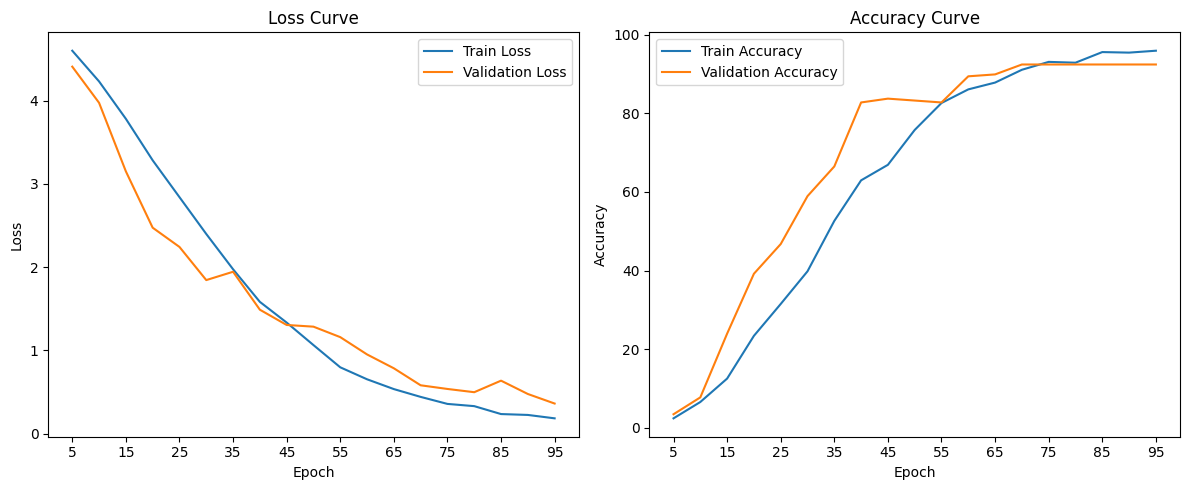

In [32]:
import matplotlib.pyplot as plt

with open("logs/training_log.json", "r") as f:
    log = json.load(f)

epochs = range(1, len(log["train_loss"]) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, log["train_loss"], label="Train Loss")
plt.plot(epochs, log["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, log["train_acc"], label="Train Accuracy")
plt.plot(epochs, log["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
test_dataset = WLDataset(
    data_path=data_path,
    video_dir=video_dir,
    landmark_dir=landmark_dir,
    subset='test',
    num_frames=64,
    img_size=224
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [60]:
loss, acc, top5_acc = evaluate(model, test_loader, criterion, device, top_k=5)
print(f"Test loss: {loss:.4f}\n"
      f"Test Top1 Accuracy: {acc:.2f}\n"
      f"Test Top5 Accuracy {top5_acc:.2f}")

Test loss: 0.5801
Test Top1 Accuracy: 92.47
Test Top5 Accuracy 94.92


# Metrics

## Top10 Acc

In [42]:
from sklearn.metrics import confusion_matrix
from collections import defaultdict

def plot_top10_accuracy_confusion_matrix(model, data_loader, class_names, device, use_amp=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            video = batch['video'].to(device)
            landmarks = batch['landmarks'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(video, landmarks, mask)
                preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for true, pred in zip(all_labels, all_preds):
        class_total[true] += 1
        if true == pred:
            class_correct[true] += 1

    class_accuracy = {
        cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
        for cls in class_total
    }

    top10_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)[:10]
    top10_indices = [cls for cls, _ in top10_classes]
    top10_names = [class_names[i] for i in top10_indices]

    filtered_true = []
    filtered_pred = []
    for true, pred in zip(all_labels, all_preds):
        if true in top10_indices and pred in top10_indices:
            filtered_true.append(top10_indices.index(true))
            filtered_pred.append(top10_indices.index(pred))

    cm = confusion_matrix(filtered_true, filtered_pred, labels=list(range(10)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=top10_names,
                yticklabels=top10_names)
    plt.title("Confusion Matrix - Top-10 Best Performing Classes")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print("\nTop-10 Class Accuracies:")
    for idx, acc in top10_classes:
        print(f"{class_names[idx]:<15}: {acc * 100:.2f}%")

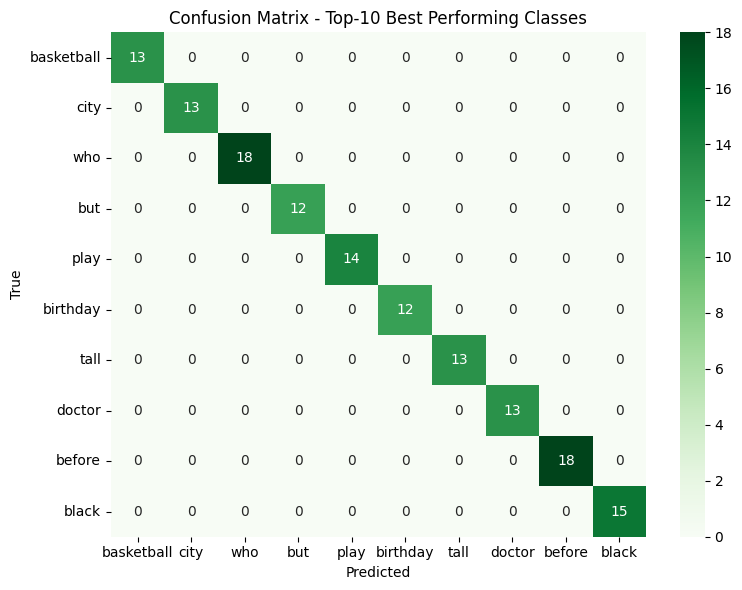


Top-10 Class Accuracies:
basketball     : 100.00%
city           : 100.00%
who            : 100.00%
but            : 100.00%
play           : 100.00%
birthday       : 100.00%
tall           : 100.00%
doctor         : 100.00%
before         : 100.00%
black          : 100.00%


In [43]:
plot_top10_accuracy_confusion_matrix(model, test_loader, class_names, device)

## Bottom5 Acc

In [67]:
from collections import Counter

def plot_bottom5_accuracy_confusion_matrix(model, data_loader, class_names, device, use_amp=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_paths = []
    misclassified_samples = []

    with torch.no_grad():
        for batch in data_loader:
            video = batch['video'].to(device)
            landmarks = batch['landmarks'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)
            paths = batch['video_path']

            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(video, landmarks, mask)
                preds = torch.argmax(outputs, dim=1)

            for i in range(len(labels)):
                true = labels[i].item()
                pred = preds[i].item()
                path = paths[i]
                all_labels.append(true)
                all_preds.append(pred)
                all_paths.append(path)

                if true != pred:
                    misclassified_samples.append({
                        'video_path': path,
                        'true_label': true,
                        'pred_label': pred
                    })

    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    for true, pred in zip(all_labels, all_preds):
        class_total[true] += 1
        if true == pred:
            class_correct[true] += 1

    class_accuracy = {
        cls: class_correct[cls] / class_total[cls]
        for cls in class_total
    }

    #filtered_accuracy = {cls: acc for cls, acc in class_accuracy.items() if acc >= 0.3}
    sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1])
    bottom_indices = [cls for cls, _ in sorted_classes[:5]]
    bottom_names = [class_names[idx] for idx in bottom_indices]

    print("\nBottom 5 classes by Accuracy:")
    for cls in bottom_indices:
        print(f"  {class_names[cls]}: {class_accuracy[cls]*100:.2f}%")

    true_filtered = []
    pred_filtered = []
    for true, pred in zip(all_labels, all_preds):
        if true in bottom_indices:
            true_filtered.append(true)
            pred_filtered.append(pred)

    if not true_filtered:
        print("No valid predictions for bottom 5 classes.")

    pred_counter = Counter(pred_filtered)
    top_pred_classes = [cls for cls, _ in pred_counter.most_common() if cls not in bottom_indices]
    top_pred_classes = top_pred_classes[:7]

    cm_pred_indices = bottom_indices + top_pred_classes
    cm_label_map = {cls: i for i, cls in enumerate(bottom_indices)}
    cm_pred_map = {cls: i for i, cls in enumerate(cm_pred_indices)}

    cm_matrix = [[0 for _ in range(len(cm_pred_indices))] for _ in range(len(bottom_indices))]
    for true, pred in zip(true_filtered, pred_filtered):
        if true in cm_label_map and pred in cm_pred_map:
            row = cm_label_map[true]
            col = cm_pred_map[pred]
            cm_matrix[row][col] += 1

    row_labels = [class_names[idx] for idx in bottom_indices]
    col_labels = [class_names[idx] for idx in cm_pred_indices]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Reds',
                xticklabels=col_labels, yticklabels=row_labels)
    plt.title("Confusion Matrix - Bottom 5 Performing Classes")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print("\nMisclassification details for Bottom 5 Performing Classes:")
    for orig_cls in bottom_indices:
        true_name = class_names[orig_cls]
        misclassified_preds = [
            pred for true, pred in zip(all_labels, all_preds)
            if true == orig_cls and pred != orig_cls
        ]
        if not misclassified_preds:
            print(f"  {true_name}: No misclassifications")
            continue

        counts = Counter(misclassified_preds)
        print(f"  {true_name} misclassified as:")
        for mis_cls, count in counts.most_common():
            pred_name = class_names[mis_cls]
            label_info = "(outside bottom-5)" if mis_cls not in bottom_indices else ""
            print(f"    {pred_name}: {count} times {label_info}")

    print("\nMisclassified video files for Bottom 5 classes:")
    for cls in bottom_indices:
        cls_name = class_names[cls]
        print(f"\nVideos for true class '{cls_name}':")
        for sample in misclassified_samples:
            if sample['true_label'] == cls:
                pred_name = class_names[sample['pred_label']]
                print(f"  Predicted as '{pred_name}' --> {sample['video_path']}")


Bottom 5 classes by Accuracy:
  want: 21.43%
  book: 50.00%
  bird: 57.14%
  yes: 66.67%
  accident: 69.23%


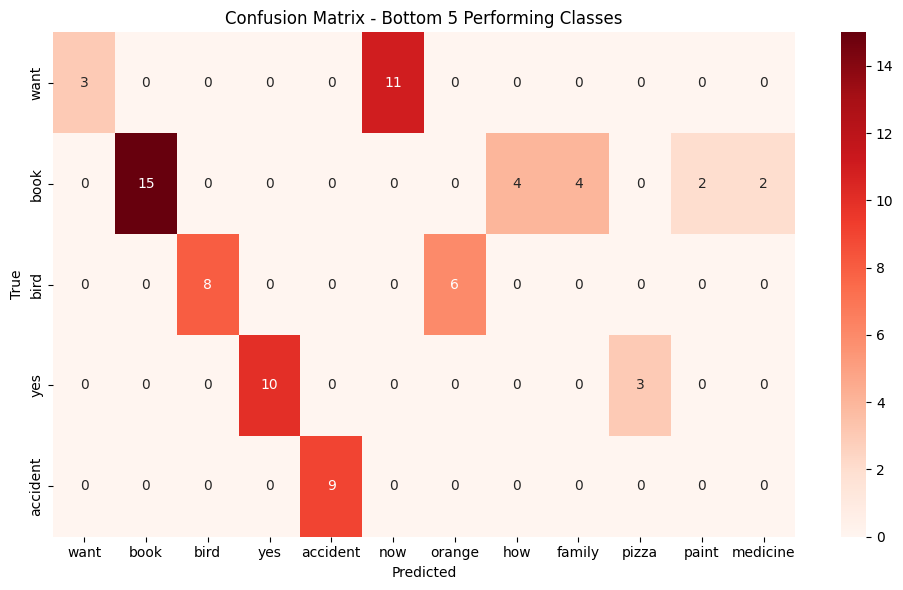


Misclassification details for Bottom 5 Performing Classes:
  want misclassified as:
    now: 11 times (outside bottom-5)
  book misclassified as:
    how: 4 times (outside bottom-5)
    family: 4 times (outside bottom-5)
    paint: 2 times (outside bottom-5)
    medicine: 2 times (outside bottom-5)
    color: 1 times (outside bottom-5)
    fish: 1 times (outside bottom-5)
    all: 1 times (outside bottom-5)
  bird misclassified as:
    orange: 6 times (outside bottom-5)
  yes misclassified as:
    pizza: 3 times (outside bottom-5)
    need: 2 times (outside bottom-5)
  accident misclassified as:
    wrong: 2 times (outside bottom-5)
    fish: 1 times (outside bottom-5)
    language: 1 times (outside bottom-5)

Misclassified video files for Bottom 5 classes:

Videos for true class 'want':
  Predicted as 'now' --> /content/videos/68178.mp4
  Predicted as 'now' --> /content/videos/62246.mp4
  Predicted as 'now' --> /content/videos/62245.mp4
  Predicted as 'now' --> /content/videos/62249.

In [72]:
plot_bottom5_accuracy_confusion_matrix(model, test_loader, class_names, device)